In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use("ggplot")
%matplotlib inline

import sys
sys.version

'3.5.3 |Anaconda custom (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]'

- 总结利用随机森林回测的具体步骤，找到进一步的研究切入点：

1）导入单品种期货数据


2）建立特征因子（labels）


3）建立机器学习目标（targets）


4）将特征因子和学习目标合并为master_dataframe

5）选取训练集+测试的时间区间；再选取验证集的时间区间

6）以数量大的target类别为基准，针对训练集，利用resample平衡target不同类别(比如0和1)的数据数量，再将labels列数据和targets列数据分开，分别为X和y

7）将X数据标准化（normalize）：平均值在0附近，方差为1

8）用train_test_split函数分割数据，得到X的训练集，X的测试集，y的训练集，y的测试集，并定义test_size（研究问题1：搞明白X_train, X_test, y_train, y_test = 

train_test_split(X, y, test_size=1/6)的运作机制）https://blog.csdn.net/kyriehe/article/details/77507473 

9）选择模型，训练并测试，并评估模型（研究问题2：model.fit(X_train, y_train)和scores(model, X_test, y_test)的运作机制）

10）先用模型默认参数训练、测试训练测试集，抛出结果（a. 预测准确率、b. f1分数、c. ROC Curve Score分布面积）

11）选择需要优化的参数字典列表，定义为grid_data，并根据a. 预测准确率、b. f1分数和c. ROC Curve Score分布面积，求出最优参数组

12）将参数重新带进模型中，打印出整体训练+测试集中，最优参数模型得出的预测准确率、F1分数以及ROC Curve Score分布面积（通常会很高，80%-90%以上，这个部分的回测曲线会非常好）

13）将此最优参数组带入模型，打印出验证集的结果（通常降低很低）（这个部分的曲线会接近实盘曲线）（研究问题3：训练、测试、验证集之间的关系和运作机制）

14）画出两种结果的回测图


In [74]:
def preprocess_df(location, file):
    df = pd.read_csv(location+file, engine="python", header=None)
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']
    return df

def get_indicators(data, n, indicator):
    
    ###### Step 1: Calculate necessary time series ######
    up, dw = data['close'].diff(), -data['close'].diff()
    up[up<0], dw[dw<0] = 0, 0
    # default set to be 12-period ema as the fast line, 26 as the slow line:
    macd = data['close'].ewm(12).mean() - data['close'].ewm(26).mean()
    # default set to be 9-period ema of the macd
    macd_signal = macd.ewm(9).mean()
    
    ###### Step 2: Create dataframe and fill with technical indicators: ######
    indicators = pd.DataFrame(data=0, index=data.index,
                              columns=['sma', 'ema', 'momentum', 'rsi', 'macd'])
#     indicators['date'] = data['date']
    indicators['sma'] = data['close'].rolling(n).mean()
    indicators['ema'] = data['close'].ewm(n).mean()
    indicators['momentum'] = data['close'] - data['close'].shift(n)
    indicators['rsi'] = 100 - 100 / (1 + up.rolling(n).mean() / dw.rolling(n).mean())
    indicators['macd'] = macd - macd_signal
    indicators.index = data['date']
    return indicators[[indicator]]

def get_data(df, n):
    # technical indicators
    sma = get_indicators(df, n, 'sma')
    ema = get_indicators(df, n, 'ema')
    momentum = get_indicators(df, n, 'momentum')
    rsi = get_indicators(df, n, 'rsi')
    macd = get_indicators(df, n, 'macd')
    tech_ind = pd.concat([sma, ema, momentum, rsi, macd], axis = 1)
    df.index = df['date']
    close = df['close']
    direction = (close > close.shift()).astype(int)
    target = direction.shift(-1).fillna(0).astype(int)
    target.name = 'target'
    master_df = pd.concat([tech_ind, close, target], axis=1)
    return master_df

def rebalance(unbalanced_data):
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    # Separate majority and minority classes
    data_minority = unbalanced_data[unbalanced_data.target==1] # get all all down days
    data_majority = unbalanced_data[unbalanced_data.target==0] # get all up days
    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=5)
    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])
    data_upsampled.sort_index(inplace=True)
    # Display new class counts
    data_upsampled.target.value_counts()
    return data_upsampled

def normalize(x):
    scaler = StandardScaler()
    # 公式为：(X-mean)/std  计算时对每个属性/每列分别进行。
    # 将数据按期属性（按列进行）减去其均值，并除以其方差。得到的结果是，对于每个属性/每列来说所有数据都聚集在0附近，方差为1。
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)
    return x_norm

def scores(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    
    
def train_test_validate(master_df, train_start, train_end, test_size, plot=True): 
    # train_start example: '2011-01-01'
    # test_size defaults as 1/6, 
    # test_size: parameter
    
    data = master_df.copy()
    data.index = pd.to_datetime(data.index)
    if plot == True:
        print ("Plotting data's close price series")
        ax = data[['close']].plot(figsize=(20, 5))
        ax.set_ylabel("Price (￥)")
        ax.set_xlabel("Time")
        plt.show()
    else:
        pass
    data_train = data[train_start : train_end]
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    data_train = rebalance(data_train).dropna()
    # y as the label target 
    y = data_train.target
    # X as the dataframe with their values to be normalized
    X = data_train.drop('target', axis=1)
    X = normalize(X)
    
    data_val = data[train_end:]
    data_val.dropna(inplace=True)
    # y_val as the label target in the validation period
    y_val = data_val.target
    # X_val as the dataframe with their values to be normalized in the validation period
    X_val = data_val.drop('target', axis=1)
    # normalize X_val dataframe
    X_val = normalize(X_val)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    print ("-----------------------------------------------")
    print ("X length: ", len(X))
    print ("X_val length: ", len(X_val))
    print ("X_train length: ", len(X_train))
    print ("X_test length: ", len(X_test))
    print ("-----------------------------------------------")
    print ("y length: ", len(y))
    print ("y_val length: ", len(y_val))
    print ("y_train length:", len(y_train))
    print ("y_test length:", len(y_test))
    print ("-----------------------------------------------")
    # Outputs of this function are 8 variables from above.
    return data, X, X_val, X_train, X_test, y, y_val, y_train, y_test
    
    
def optimize_model_paras(X_train, y_train, X_test, y_test):
    # first take a look at the default model's results:
    model = RandomForestClassifier(random_state=5)
    print ("Training default model...")
    model.fit(X_train, y_train)
    print ("Default model's scores:")
    scores(model, X_test, y_test)
    # set up parameters to be optimized
    grid_data =   {'n_estimators': [10, 50, 100],
                   'criterion': ['gini', 'entropy'],
                   'max_depth': [None, 10, 50, 100],
                   'min_samples_split': [2, 5, 10],
                   'random_state': [5]}
    grid = GridSearchCV(model, grid_data, scoring='f1').fit(X_train, y_train)
    print ("-----------------------------------------------")
    print ("Model's best parameters: ")
    print(grid.best_params_)
    model = grid.best_estimator_
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Performance of the train_test datasets: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    print ("Optimized Model from the train_test dataset: ", model)
    
    # Validate optimized model:
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    
    optimized_model = model
    return optimized_model

def train_test_backtest(optimized_model, X, X_train, y_train):
    rf_model = optimized_model
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X)
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['close'].diff()
    data_returns = data_returns[X.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum()
    equity = model_returns.sum()
    start_close = data["close"][X.index[0]]
    performance = equity / start_close * 100
#     ax = model_returns.plot(figsize=(15, 8))
#     ax.set_ylabel("Returns (￥)")
#     ax.set_xlabel("Time")
#     plt.show()
    ax = model_cum.plot(figsize=(15, 8))
    ax.set_ylabel("Cummulative returns (￥)")
    ax.set_xlabel("Time")
    plt.show()
    return model_cum, equity, performance, mask, y_pred, data_returns


# Trading system: testing real performance:
def validate_backtest(optimized_model, X_val, X_train, y_train):
    rf_model = optimized_model
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['close'].diff()
    data_returns = data_returns[X_val.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum()
    equity = model_returns.sum()
    start_close = data["close"][X_val.index[0]]
    performance = equity / start_close * 100
#     ax = model_returns.plot(figsize=(15, 8))
#     ax.set_ylabel("Returns ($)")
#     ax.set_xlabel("Time")
#     plt.show()
    ax = model_cum.plot(figsize=(15, 8))
    ax.set_ylabel("Cummulative returns ($)")
    ax.set_xlabel("Time")
    plt.show()
    return model_cum, equity, performance, mask, y_pred, data_returns

# Create signal file that is to be imported to TB:
def create_TB_signal_df(df, X_val, y_pred, y_val, mask, data_returns, exported_file):
    print ("Processing signal dataframe...")
    master_pred_df = X_val.copy()
    master_pred_df['y_pred'] = y_pred
    master_pred_df['y_val'] = y_val
    master_pred_df['mask'] = mask
    master_pred_df['data_returns'] = data_returns
    master_pred_df['model_returns'] = mask * data_returns
    master_pred_df_dt = master_pred_df.copy()
    master_pred_df_dt.reset_index(inplace = True)
    
    print ("Processing original OHLCV dataframe...")
    df_dt = df.copy()
    del df_dt['date']
    df_dt.reset_index(inplace= True)
    df_dt['date'] = pd.to_datetime(df_dt['date'])

    print ("Merging signal dataframe and OHLCV dataframe...")
    master_pred_df_dt = master_pred_df_dt[['date', 'mask']]
    merged = df_dt[['date', 'open', 'high', 'low', 'close']].merge(master_pred_df_dt, on = 'date')
    merged.columns = ['date', 'open', 'high', 'low', 'close', 'signals']
    
    print ("Exporting final signal file...")
    merged.to_csv(location + exported_file, index = False, header = False)
    print ("All done!")
    
    return merged, master_pred_df

Plotting data's close price series


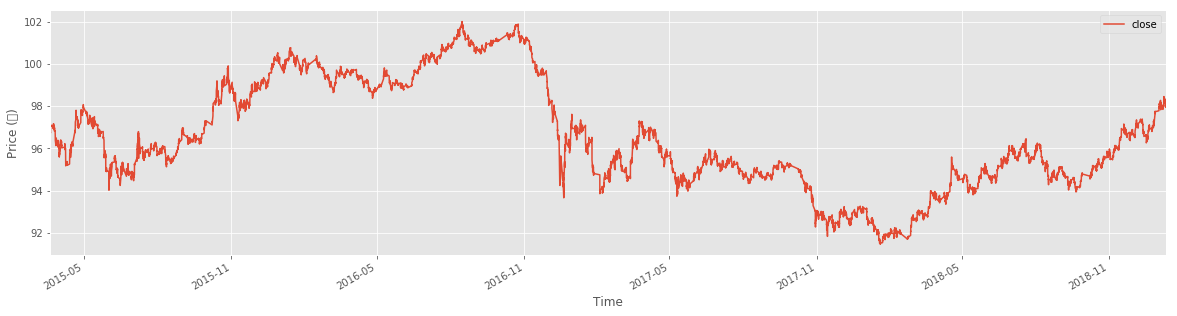

-----------------------------------------------
X length:  8205
X_val length:  8910
X_train length:  6837
X_test length:  1368
-----------------------------------------------
y length:  8205
y_val length:  8910
y_train length: 6837
y_test length: 1368
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [75]:
# Part 1:
location =  "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_11_minute_data/15_min_data/"
file = "T9000_15mins.csv"
df = preprocess_df(location, file)

# Part 2:
master_df = get_data(df, 10)

# Part 3:
data, X, X_val, X_train, X_test, y, y_val, y_train, y_test = train_test_validate(master_df, '2011-01-01','2017-01-01', 1/6, True)

In [65]:
# Part 4: unnecessary function to run if we already have all optimized parameters
# optimized_model = optimize_model_paras(X_train, y_train, X_test, y_test)

In [76]:
# Part 4: if we already have all optimized parameters we just run this step: 
optmzd_model = RandomForestClassifier(
            bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False
            )

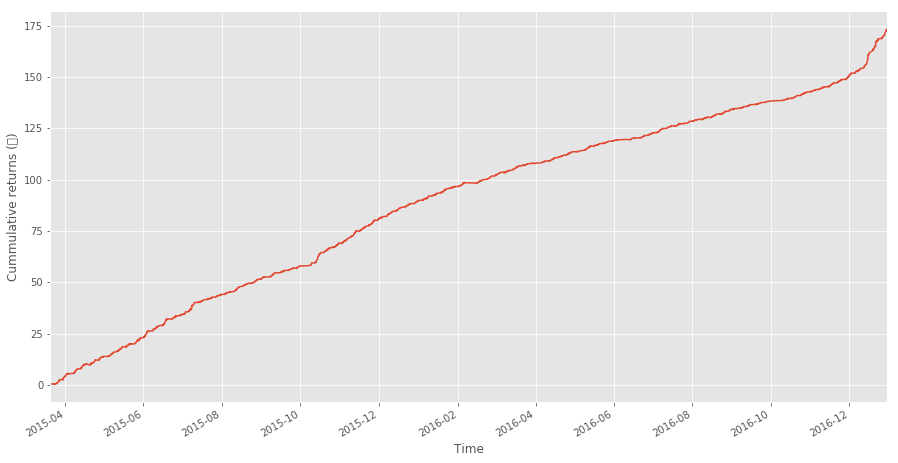

In [77]:
# Part 5: See in-sample backtest
model_cum, equity, performance, mask, y_pred, data_returns = train_test_backtest(optmzd_model, X, X_train, y_train)

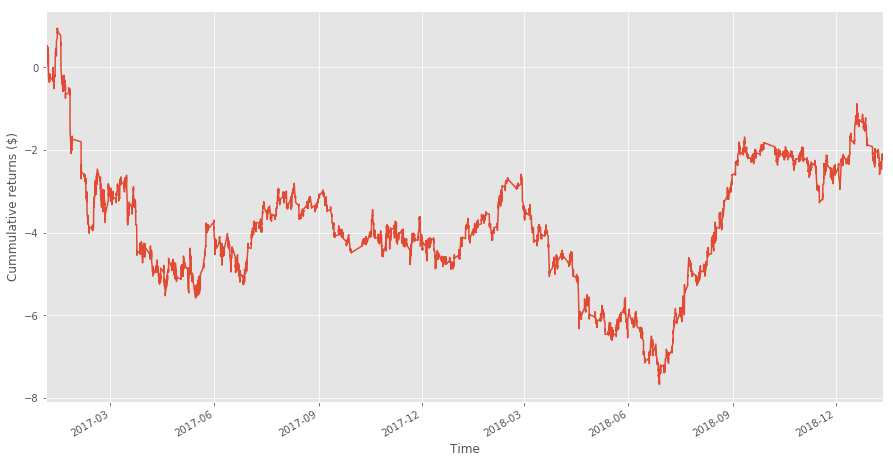

In [78]:
# Part 6: See out-of-sample backtest
model_cum_, equity_, performance_, mask_, y_pred_, data_returns_ = validate_backtest(optmzd_model, X_val, X_train, y_train)

In [57]:
# Part 7: Merge OHLCV dataframe and signal dataframe:

merged, master_pred_df = create_TB_signal_df(df, X_val, y_pred_, y_val, mask_, data_returns_, 'testing_.csv')

Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!


In [59]:
merged.head()

,date,open,high,low,close,signals
0,2017-01-03,1531.5,1608.5,1490.5,1494.5,-1
1,2017-01-04,1495.5,1517.0,1456.5,1504.5,1
2,2017-01-05,1502.0,1534.5,1495.5,1514.5,1
3,2017-01-06,1505.5,1572.0,1494.5,1537.0,1
4,2017-01-09,1537.0,1593.5,1518.0,1593.0,-1


In [64]:
master_pred_df

,sma,ema,momentum,rsi,macd,close,y_pred,y_val,mask,data_returns,model_returns
date,,,,,,,,,,,
2017-01-03,-1.199053,-0.996413,-2.255754,-2.208061,-2.418007,-1.779837,1,1,-1,-47.5,47.5
2017-01-04,-1.325772,-1.076372,-2.301567,-2.292586,-2.465698,-1.743736,1,1,1,10.0,10.0
2017-01-05,-1.445155,-1.145488,-2.170672,-2.166062,-2.463567,-1.707635,1,1,1,10.0,10.0
2017-01-06,-1.514474,-1.200279,-1.277320,-1.701812,-2.405986,-1.626407,0,1,1,22.5,22.5
2017-01-09,-1.558303,-1.230073,-0.822463,-0.979901,-2.264207,-1.424240,0,1,-1,56.0,-56.0
2017-01-10,-1.535747,-1.225884,0.362129,0.351100,-2.018806,-1.108354,0,0,-1,87.5,-87.5
2017-01-11,-1.517042,-1.229760,0.293410,0.260486,-1.823117,-1.185971,0,1,-1,-21.5,21.5
2017-01-12,-1.486233,-1.224885,0.509385,0.472905,-1.615715,-1.101133,0,1,-1,23.5,-23.5
2017-01-13,-1.447356,-1.217415,0.653369,0.635839,-1.419159,-1.070447,0,1,-1,8.5,-8.5
